In [148]:
import pandas as pd
import os
import numpy as np
import torch
os.chdir('/home/tm_ba/Desktop/Bachelorarbeit_code')

In [149]:
df = pd.read_csv("csv_new/processed_Trajectories.csv")
df = df.rename(columns={"Recording": "Sequence"}).drop("Sub Frame", axis=1)
df

,Frame,Mathew:shoulder:X (mm),Mathew:shoulder:Y (mm),Mathew:shoulder:Z (mm),Mathew:shoulderElbowSupport:X (mm),Mathew:shoulderElbowSupport:Y (mm),Mathew:shoulderElbowSupport:Z (mm),Mathew:elbow:X (mm),Mathew:elbow:Y (mm),Mathew:elbow:Z (mm),...,Mathew:elbowWrist:X (mm),Mathew:elbowWrist:Y (mm),Mathew:elbowWrist:Z (mm),Mathew:Triangle2:X (mm),Mathew:Triangle2:Y (mm),Mathew:Triangle2:Z (mm),Mathew:ThumbTip:X (mm),Mathew:ThumbTip:Y (mm),Mathew:ThumbTip:Z (mm),Sequence
0,1,424.573,31.46390,632.820,468.277,46.7705,443.600,437.244,95.0522,303.700,...,396.319,145.3050,191.947,246.222,197.514,74.8402,208.065,226.836,58.5300,0
1,2,424.260,31.44500,632.718,467.946,47.3265,443.768,436.375,95.5444,304.092,...,394.630,146.3600,192.751,244.034,197.688,75.1489,205.831,226.619,58.8733,0
2,3,424.073,31.44570,632.837,467.521,47.7943,443.758,435.643,96.2625,304.070,...,393.247,147.4150,193.529,241.699,197.913,76.6041,203.393,225.856,59.2708,0
3,4,423.898,31.59660,632.891,467.049,48.2684,443.627,434.516,96.9949,304.057,...,391.708,148.0680,194.022,239.639,198.164,78.2239,200.365,225.176,59.9573,0
4,5,423.604,31.65990,632.974,466.561,48.8856,443.475,433.747,97.6751,303.587,...,390.033,149.0990,194.498,237.279,198.358,78.9482,197.646,224.697,60.5265,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29035,484,472.782,-7.33897,652.253,535.728,-16.3590,461.963,554.699,35.5385,328.978,...,581.487,93.6361,215.385,552.405,245.451,78.3614,553.403,289.602,36.5813,50
29036,485,472.814,-7.35831,652.198,535.742,-16.4615,461.932,554.922,35.4013,329.154,...,581.569,93.5538,215.329,552.566,245.691,78.9424,553.230,289.540,36.6210,50
29037,486,472.883,-7.35738,652.159,535.819,-16.5510,461.839,555.211,35.2621,329.311,...,581.622,93.4419,215.321,552.636,245.788,79.3251,553.066,289.457,36.4266,50
29038,487,472.944,-7.36919,652.078,535.896,-16.7327,461.831,555.527,35.0052,329.505,...,581.873,93.4184,215.278,552.639,245.982,79.6639,552.995,289.511,36.4619,50


In [147]:
df.value_counts("Sequence")

Sequence
18.0    993
14.0    804
28.0    766
31.0    761
48.0    757
       ... 
28.5      1
14.5      1
16.5      1
17.5      1
22.5      1
Name: count, Length: 101, dtype: int64

In [57]:
# Joints of interest
joints = ['shoulder', 'shoulderElbowSupport', 'elbow', 'wrist', 'elbowWrist', 'Triangle2', 'ThumbTip']
coordinates = ['X', 'Y', 'Z']

# Convert 'mm' to 'm' (if needed, since robot arms often use meters)
df[[f'Mathew:{joint}:{coord} (mm)' for joint in joints for coord in coordinates]] /= 1000

# Calculate velocity (difference in position between frames)
def calculate_velocity(df, joints, coordinates):
    velocity_df = pd.DataFrame()
    for joint in joints:
        for coord in coordinates:
            position_col = f'Mathew:{joint}:{coord} (mm)'
            velocity_col = f'{joint}:{coord}_velocity'
            velocity_df[velocity_col] = df.groupby('Sequence')[position_col].diff().fillna(0)  # Calculate difference between time steps
    velocity_df["Sequence"] = df["Sequence"]
    return velocity_df

# Calculate acceleration (difference in velocity between frames)
def calculate_acceleration(velocity_df, joints, coordinates):
    acceleration_df = pd.DataFrame()
    for joint in joints:
        for coord in coordinates:
            velocity_col = f'{joint}:{coord}_velocity'
            acceleration_col = f'{joint}:{coord}_acceleration'
            acceleration_df[acceleration_col] = velocity_df.groupby('Sequence')[velocity_col].diff().fillna(0)  # Difference between velocities
    acceleration_df["Sequence"] = df["Sequence"]
    return acceleration_df

# Calculate velocity and acceleration
velocity_df = calculate_velocity(df, joints, coordinates)
acceleration_df = calculate_acceleration(velocity_df, joints, coordinates)

# Merge position, velocity, and acceleration into one DataFrame
full_data = pd.concat([df, velocity_df, acceleration_df], axis=1).drop(columns=["Sequence"])
full_data["Sequence"] = df["Sequence"]

# Organize by sequence: Create sequences for the model
sequences = full_data.groupby('Sequence').apply(lambda group: group.drop(columns=['Frame', 'Sequence']).values).values

# Example: Sequences of joint positions, velocity, and acceleration for input
X = []
Y = []

# Prepare the data: Input (X) will be current positions, velocities, accelerations
# Output (Y) will be the next time step's positions

for seq in sequences:
    # Each sequence is a separate time-series for one movement
    for i in range(len(seq) - 1):  # We stop at len(seq)-1 to predict the next time step
        X.append(seq[i])  # Input: current time step (positions, velocity, acceleration)
        Y.append(seq[i+1][:len(joints)*3])  # Output: next time step's positions (x, y, z)

# Convert to numpy arrays
X = np.array(X)
Y = np.array(Y)

# X shape: (num_samples, num_features) -- for LSTMs, should reshape to (num_samples, timesteps, num_features)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (28939, 63)
Y shape: (28939, 21)


/tmp/ipykernel_212289/3887858029.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sequences = full_data.groupby('Sequence').apply(lambda group: group.drop(columns=['Frame', 'Sequence']).values).values


In [146]:
full_data.value_counts("Sequence")

Sequence
18.0    993
14.0    804
28.0    766
31.0    761
48.0    757
       ... 
28.5      1
14.5      1
16.5      1
17.5      1
22.5      1
Name: count, Length: 101, dtype: int64

In [145]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Group data by sequence
grouped = full_data.groupby('Sequence')

# Prepare input (X) and output (Y) for each sequence individually
X_seqs = []
Y_seqs = []
lengths = []  # To store original sequence lengths

for _, group in grouped:
    X_seq = torch.tensor(group.drop(columns=['Frame', 'Sequence']).values[:-1], dtype=torch.float32)  # Input sequence (positions, velocities, accelerations)
    Y_seq = torch.tensor(group[['Mathew:shoulder:X (mm)', 'Mathew:shoulder:Y (mm)', 'Mathew:shoulder:Z (mm)',  # Output sequence (next positions)
                   'Mathew:shoulderElbowSupport:X (mm)', 'Mathew:shoulderElbowSupport:Y (mm)', 'Mathew:shoulderElbowSupport:Z (mm)',
                   'Mathew:elbow:X (mm)', 'Mathew:elbow:Y (mm)', 'Mathew:elbow:Z (mm)',
                   'Mathew:wrist:X (mm)', 'Mathew:wrist:Y (mm)', 'Mathew:wrist:Z (mm)',
                   'Mathew:elbowWrist:X (mm)', 'Mathew:elbowWrist:Y (mm)', 'Mathew:elbowWrist:Z (mm)',
                   'Mathew:Triangle2:X (mm)', 'Mathew:Triangle2:Y (mm)', 'Mathew:Triangle2:Z (mm)',
                   'Mathew:ThumbTip:X (mm)', 'Mathew:ThumbTip:Y (mm)', 'Mathew:ThumbTip:Z (mm)']].values[1:], dtype=torch.float32)  # Next positions
    
    # Only add non-empty sequences
    if len(X_seq) > 0 and len(Y_seq) > 0:
        X_seqs.append(X_seq)
        Y_seqs.append(Y_seq)
        # Store original length before padding
        lengths.append(len(X_seq))
        print("VALS NON NONE:", group.values.shape)

    else:
        print("VALS NONE:", group.values.shape)


# Pad sequences to the same length using PyTorch pad_sequence
X_padded = pad_sequence(X_seqs, batch_first=True, padding_value=0.0)
Y_padded = pad_sequence(Y_seqs, batch_first=True, padding_value=0.0)

# Convert original lengths to PyTorch tensor
lengths_tensor = torch.tensor(lengths)

# X_padded and Y_padded are now properly grouped by sequence, with padding if necessary
print("X_padded shape:", X_padded.shape)
print("Y_padded shape:", Y_padded.shape)
print("Lengths shape:", lengths_tensor.shape)


VALS NON NONE: (475, 65)
VALS NONE: (1, 65)
0.5
VALS NON NONE: (611, 65)
VALS NONE: (1, 65)
1.5
VALS NON NONE: (662, 65)
VALS NONE: (1, 65)
2.5
VALS NON NONE: (521, 65)
VALS NONE: (1, 65)
3.5
VALS NON NONE: (445, 65)
VALS NONE: (1, 65)
4.5
VALS NON NONE: (601, 65)
VALS NONE: (1, 65)
5.5
VALS NON NONE: (637, 65)
VALS NONE: (1, 65)
6.5
VALS NON NONE: (634, 65)
VALS NONE: (1, 65)
7.5
VALS NON NONE: (522, 65)
VALS NONE: (1, 65)
8.5
VALS NON NONE: (660, 65)
VALS NONE: (1, 65)
9.5
VALS NON NONE: (436, 65)
VALS NONE: (1, 65)
10.5
VALS NON NONE: (639, 65)
VALS NONE: (1, 65)
11.5
VALS NON NONE: (473, 65)
VALS NONE: (1, 65)
12.5
VALS NON NONE: (543, 65)
VALS NONE: (1, 65)
13.5
VALS NON NONE: (804, 65)
VALS NONE: (1, 65)
14.5
VALS NON NONE: (547, 65)
VALS NONE: (1, 65)
15.5
VALS NON NONE: (433, 65)
VALS NONE: (1, 65)
16.5
VALS NON NONE: (446, 65)
VALS NONE: (1, 65)
17.5
VALS NON NONE: (993, 65)
VALS NONE: (1, 65)
18.5
VALS NON NONE: (456, 65)
VALS NONE: (1, 65)
19.5
VALS NON NONE: (434, 65)
VALS 

In [140]:
X_seqs[7].shape

torch.Size([633, 63])

### Step 1: Data Normalization

In [96]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

class MotionDataset(Dataset):
    def __init__(self, X, Y, X_mean=None, X_std=None, Y_mean=None, Y_std=None):
        self.X = X
        self.Y = Y
        self.X_mean = X_mean
        self.X_std = X_std
        self.Y_mean = Y_mean
        self.Y_std = Y_std

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        X_item = self.X[idx]
        Y_item = self.Y[idx]
        
        # Apply normalization if mean and std are provided
        if self.X_mean is not None and self.X_std is not None:
            X_item = (X_item - self.X_mean) / self.X_std
        if self.Y_mean is not None and self.Y_std is not None:
            Y_item = (Y_item - self.Y_mean) / self.Y_std
        
        return X_item, Y_item


In [120]:
# Convert data to PyTorch tensors
X = torch.tensor(X_padded, dtype=torch.float32)
Y = torch.tensor(Y_padded, dtype=torch.float32)

# Split data into training, validation, and test sets
dataset_size = X.shape[0]
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Create the dataset
full_dataset = MotionDataset(X, Y)

# Split the lengths tensor in the same way as the dataset
lengths_tensor = torch.tensor(lengths, dtype=torch.long)  # Make sure lengths_tensor is long type

# Calculate the indices for splitting
train_idx = range(0, train_size)
val_idx = range(train_size, train_size + val_size)
test_idx = range(train_size + val_size, dataset_size)

# Split the lengths tensor using the same indices
lengths_train = lengths_tensor[train_idx]
lengths_val = lengths_tensor[val_idx]
lengths_test = lengths_tensor[test_idx]

# Split the dataset using the same proportions
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Compute mean and std from ONLY the training data
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=len(dataset))
    X_batch, Y_batch = next(iter(loader))
    X_flat = X_batch.view(-1, X_batch.shape[-1])
    Y_flat = Y_batch.view(-1, Y_batch.shape[-1])
    X_mean = X_flat.mean(dim=0)
    X_std = X_flat.std(dim=0)
    Y_mean = Y_flat.mean(dim=0)
    Y_std = Y_flat.std(dim=0)
    # Avoid division by zero (to handle any constant feature)
    X_std[X_std == 0] = 1
    Y_std[Y_std == 0] = 1
    return X_mean, X_std, Y_mean, Y_std

# Compute mean and std from the training set
X_mean, X_std, Y_mean, Y_std = compute_mean_std(train_dataset)

# Create normalized datasets for training, validation, and test sets
train_dataset = MotionDataset(train_dataset.dataset.X, train_dataset.dataset.Y, X_mean, X_std, Y_mean, Y_std)
val_dataset = MotionDataset(val_dataset.dataset.X, val_dataset.dataset.Y, X_mean, X_std, Y_mean, Y_std)
test_dataset = MotionDataset(test_dataset.dataset.X, test_dataset.dataset.Y, X_mean, X_std, Y_mean, Y_std)

# Now you have lengths_train, lengths_val, and lengths_test corresponding to each dataset


/tmp/ipykernel_212289/1745333215.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X_padded, dtype=torch.float32)
/tmp/ipykernel_212289/1745333215.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y_padded, dtype=torch.float32)


### Step 2: Model Implementation

In [121]:
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.W = nn.Linear(hidden_dim * 2, hidden_dim * 2, bias=False)
        self.u = nn.Linear(hidden_dim * 2, 1, bias=False)
        
    def forward(self, inputs, mask):
        # inputs: [batch_size, seq_len, hidden_dim*2]
        # mask: [batch_size, seq_len]
        
        # Linear transformation
        u_it = torch.tanh(self.W(inputs))  # [batch_size, seq_len, hidden_dim*2]
        
        # Compute attention scores
        a_it = self.u(u_it).squeeze(-1)  # [batch_size, seq_len]
        
        # Apply mask (set scores of padded elements to a large negative value)
        a_it = a_it.masked_fill(~mask, float('-1e9'))
        
        # Compute attention weights
        a_it = F.softmax(a_it, dim=1)  # [batch_size, seq_len]
        
        # Ensure no NaNs
        a_it = a_it * mask.float()  # Zero out weights where mask is False
        a_it = a_it / (a_it.sum(dim=1, keepdim=True) + 1e-9)
        
        # Compute weighted sum of inputs
        context = torch.bmm(a_it.unsqueeze(1), inputs).squeeze(1)  # [batch_size, hidden_dim*2]
        
        return context


In [122]:
class MotionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(MotionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, bidirectional=True, dropout=0.2
        )
        
        self.attention = AttentionLayer(hidden_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim)
        )
    
    def forward(self, x, lengths):
        # x: [batch_size, seq_len, input_dim]
        # lengths: [batch_size]
        
        # Pack padded sequence
        packed_input = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # LSTM
        packed_output, _ = self.lstm(packed_input)
        
        # Unpack sequence
        output, _ = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True
        )
        # output: [batch_size, seq_len, hidden_dim*2]
        
        # Create mask based on the correct sequence lengths (original, not padded)
        max_len = output.size(1)
        mask = torch.arange(max_len, device=lengths.device).expand(len(lengths), max_len) < lengths.unsqueeze(1)
        # mask: [batch_size, seq_len]

        
        # Attention
        context = self.attention(output, mask)
        
        # Repeat context to match sequence length
        context = context.unsqueeze(1).expand(-1, max_len, -1)
        
        # Concatenate LSTM outputs with context
        combined = torch.cat((output, context), dim=2)
        # combined: [batch_size, seq_len, hidden_dim*4]
        
        # Output layer
        outputs = self.fc(combined)
        # outputs: [batch_size, seq_len, output_dim]
        
        return outputs, mask



### Step 3: Custom Loss Function

In [123]:
def custom_loss(y_pred, y_true, mask):
    # mask: [batch_size, seq_len]
    mask = mask.unsqueeze(-1)  # [batch_size, seq_len, 1]
    mask = mask.float()
    
    # Position loss
    position_loss = ((y_true - y_pred) ** 2) * mask
    position_loss = position_loss.sum() / mask.sum()
    
    # Compute velocities
    def compute_velocity(y):
        y_shifted = torch.zeros_like(y)
        y_shifted[:, 1:, :] = y[:, :-1, :]
        velocity = (y - y_shifted) * mask
        return velocity
    
    # Compute accelerations
    def compute_acceleration(v):
        v_shifted = torch.zeros_like(v)
        v_shifted[:, 1:, :] = v[:, :-1, :]
        acceleration = (v - v_shifted) * mask
        return acceleration
    
    # Predicted velocities and accelerations
    pred_velocity = compute_velocity(y_pred)
    pred_acceleration = compute_acceleration(pred_velocity)
    
    # True velocities and accelerations
    true_velocity = compute_velocity(y_true)
    true_acceleration = compute_acceleration(true_velocity)
    
    # Velocity loss
    velocity_loss = ((true_velocity - pred_velocity) ** 2) * mask
    velocity_loss = velocity_loss.sum() / mask.sum()
    
    # Acceleration loss
    acceleration_loss = ((true_acceleration - pred_acceleration) ** 2) * mask
    acceleration_loss = acceleration_loss.sum() / mask.sum()
    
    # Total loss with weighting
    total_loss = (
        position_loss
        + 0.1 * velocity_loss
        + 0.01 * acceleration_loss
    )
    return total_loss


### Step 4: Model Training

In [124]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # batch is a list of tuples (X_item, Y_item)
    X_batch, Y_batch = zip(*batch)
    lengths = [x.size(0) for x in X_batch]
    # Pad sequences
    X_padded = pad_sequence(X_batch, batch_first=True, padding_value=0.0)
    Y_padded = pad_sequence(Y_batch, batch_first=True, padding_value=0.0)
    lengths = torch.tensor(lengths)
    return X_padded, Y_padded, lengths

batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)


In [125]:
input_dim = X.shape[2]
hidden_dim = 128
output_dim = Y.shape[2]
num_layers = 2

# Initialize the model
model = MotionModel(input_dim, hidden_dim, output_dim, num_layers)

# Use DataParallel for multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using 2 GPUs


In [126]:
from tqdm import tqdm

num_epochs = 100
best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, Y_batch, lengths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        lengths = lengths.to(device)  # Original lengths, not padded lengths
        
        optimizer.zero_grad()
        outputs, mask = model(X_batch, lengths)  # Pass correct lengths for masking
        
        loss = custom_loss(outputs, Y_batch, mask)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_dataset)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch, lengths in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            lengths = lengths.to(device)  # Original lengths, not padded lengths
            
            outputs, mask = model(X_batch, lengths)  # Pass correct lengths for masking
            
            loss = custom_loss(outputs, Y_batch, mask)
            val_loss += loss.item() * X_batch.size(0)

    val_loss /= len(val_dataset)
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping")
            break


Epoch 1/100: 100%|██████████| 4/4 [00:00<00:00, 10.24it/s]


Epoch 1, Train Loss: 19.910585, Val Loss: 17.127990


Epoch 2/100: 100%|██████████| 4/4 [00:00<00:00, 12.23it/s]


Epoch 2, Train Loss: 14.804053, Val Loss: 7.156998


Epoch 3/100: 100%|██████████| 4/4 [00:00<00:00, 11.84it/s]


Epoch 3, Train Loss: 6.822354, Val Loss: 5.225240


Epoch 4/100: 100%|██████████| 4/4 [00:00<00:00, 11.45it/s]


Epoch 4, Train Loss: 5.950885, Val Loss: 3.154299


Epoch 5/100: 100%|██████████| 4/4 [00:00<00:00, 11.15it/s]


Epoch 5, Train Loss: 3.979995, Val Loss: 2.533587


Epoch 6/100: 100%|██████████| 4/4 [00:00<00:00, 10.38it/s]


Epoch 6, Train Loss: 3.236306, Val Loss: 1.944134


Epoch 7/100: 100%|██████████| 4/4 [00:00<00:00, 10.86it/s]


Epoch 7, Train Loss: 2.766630, Val Loss: 1.725729


Epoch 8/100: 100%|██████████| 4/4 [00:00<00:00, 10.32it/s]


Epoch 8, Train Loss: 2.414662, Val Loss: 1.419071


Epoch 9/100: 100%|██████████| 4/4 [00:00<00:00, 11.02it/s]


Epoch 9, Train Loss: 2.162936, Val Loss: 1.222575


Epoch 10/100: 100%|██████████| 4/4 [00:00<00:00, 11.12it/s]


Epoch 10, Train Loss: 1.856806, Val Loss: 1.013167


Epoch 11/100: 100%|██████████| 4/4 [00:00<00:00, 10.35it/s]


Epoch 11, Train Loss: 1.621598, Val Loss: 0.868770


Epoch 12/100: 100%|██████████| 4/4 [00:00<00:00, 10.93it/s]


Epoch 12, Train Loss: 1.374980, Val Loss: 0.724226


Epoch 13/100: 100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


Epoch 13, Train Loss: 1.256446, Val Loss: 0.607667


Epoch 14/100: 100%|██████████| 4/4 [00:00<00:00, 10.22it/s]


Epoch 14, Train Loss: 1.095421, Val Loss: 0.541345


Epoch 15/100: 100%|██████████| 4/4 [00:00<00:00, 12.34it/s]


Epoch 15, Train Loss: 1.052721, Val Loss: 0.463478


Epoch 16/100: 100%|██████████| 4/4 [00:00<00:00, 11.01it/s]


Epoch 16, Train Loss: 0.942064, Val Loss: 0.418848


Epoch 17/100: 100%|██████████| 4/4 [00:00<00:00, 10.66it/s]


Epoch 17, Train Loss: 0.852170, Val Loss: 0.340766


Epoch 18/100: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


Epoch 18, Train Loss: 0.793865, Val Loss: 0.241969


Epoch 19/100: 100%|██████████| 4/4 [00:00<00:00, 10.86it/s]


Epoch 19, Train Loss: 0.731096, Val Loss: 0.236144


Epoch 20/100: 100%|██████████| 4/4 [00:00<00:00, 10.62it/s]


Epoch 20, Train Loss: 0.655705, Val Loss: 0.191101


Epoch 21/100: 100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch 21, Train Loss: 0.617284, Val Loss: 0.169231


Epoch 22/100: 100%|██████████| 4/4 [00:00<00:00, 10.73it/s]


Epoch 22, Train Loss: 0.574825, Val Loss: 0.143195


Epoch 23/100: 100%|██████████| 4/4 [00:00<00:00, 11.19it/s]


Epoch 23, Train Loss: 0.547556, Val Loss: 0.128803


Epoch 24/100: 100%|██████████| 4/4 [00:00<00:00, 11.39it/s]


Epoch 24, Train Loss: 0.522436, Val Loss: 0.144918


Epoch 25/100: 100%|██████████| 4/4 [00:00<00:00, 11.03it/s]


Epoch 25, Train Loss: 0.504829, Val Loss: 0.118789


Epoch 26/100: 100%|██████████| 4/4 [00:00<00:00, 11.50it/s]


Epoch 26, Train Loss: 0.480239, Val Loss: 0.111280


Epoch 27/100: 100%|██████████| 4/4 [00:00<00:00, 10.80it/s]


Epoch 27, Train Loss: 0.459157, Val Loss: 0.100968


Epoch 28/100: 100%|██████████| 4/4 [00:00<00:00, 10.80it/s]


Epoch 28, Train Loss: 0.444553, Val Loss: 0.117379


Epoch 29/100: 100%|██████████| 4/4 [00:00<00:00, 11.83it/s]


Epoch 29, Train Loss: 0.440789, Val Loss: 0.091297


Epoch 30/100: 100%|██████████| 4/4 [00:00<00:00, 11.45it/s]


Epoch 30, Train Loss: 0.417666, Val Loss: 0.092896


Epoch 31/100: 100%|██████████| 4/4 [00:00<00:00, 11.50it/s]


Epoch 31, Train Loss: 0.409515, Val Loss: 0.084449


Epoch 32/100: 100%|██████████| 4/4 [00:00<00:00, 11.43it/s]


Epoch 32, Train Loss: 0.399376, Val Loss: 0.082042


Epoch 33/100: 100%|██████████| 4/4 [00:00<00:00, 12.08it/s]


Epoch 33, Train Loss: 0.396150, Val Loss: 0.078990


Epoch 34/100: 100%|██████████| 4/4 [00:00<00:00, 10.76it/s]


Epoch 34, Train Loss: 0.388855, Val Loss: 0.093333


Epoch 35/100: 100%|██████████| 4/4 [00:00<00:00, 10.84it/s]


Epoch 35, Train Loss: 0.380377, Val Loss: 0.081444


Epoch 36/100: 100%|██████████| 4/4 [00:00<00:00, 11.02it/s]


Epoch 36, Train Loss: 0.371090, Val Loss: 0.079243


Epoch 37/100: 100%|██████████| 4/4 [00:00<00:00, 10.88it/s]


Epoch 37, Train Loss: 0.363571, Val Loss: 0.082494


Epoch 38/100: 100%|██████████| 4/4 [00:00<00:00, 10.61it/s]


Epoch 38, Train Loss: 0.363267, Val Loss: 0.077155


Epoch 39/100: 100%|██████████| 4/4 [00:00<00:00, 12.13it/s]


Epoch 39, Train Loss: 0.359710, Val Loss: 0.066850


Epoch 40/100: 100%|██████████| 4/4 [00:00<00:00, 11.47it/s]


Epoch 40, Train Loss: 0.354202, Val Loss: 0.087519


Epoch 41/100: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s]


Epoch 41, Train Loss: 0.363980, Val Loss: 0.081685


Epoch 42/100: 100%|██████████| 4/4 [00:00<00:00, 10.69it/s]


Epoch 42, Train Loss: 0.352989, Val Loss: 0.096006


Epoch 43/100: 100%|██████████| 4/4 [00:00<00:00, 11.36it/s]


Epoch 43, Train Loss: 0.369623, Val Loss: 0.112438


Epoch 44/100: 100%|██████████| 4/4 [00:00<00:00, 11.52it/s]


Epoch 44, Train Loss: 0.362575, Val Loss: 0.100835


Epoch 45/100: 100%|██████████| 4/4 [00:00<00:00, 10.74it/s]


Epoch 45, Train Loss: 0.350869, Val Loss: 0.086794


Epoch 46/100: 100%|██████████| 4/4 [00:00<00:00, 11.17it/s]


Epoch 46, Train Loss: 0.341602, Val Loss: 0.078666


Epoch 47/100: 100%|██████████| 4/4 [00:00<00:00, 10.99it/s]


Epoch 47, Train Loss: 0.335269, Val Loss: 0.072794


Epoch 48/100: 100%|██████████| 4/4 [00:00<00:00, 10.71it/s]


Epoch 48, Train Loss: 0.331013, Val Loss: 0.059147


Epoch 49/100: 100%|██████████| 4/4 [00:00<00:00, 11.06it/s]


Epoch 49, Train Loss: 0.327627, Val Loss: 0.058040


Epoch 50/100: 100%|██████████| 4/4 [00:00<00:00, 12.07it/s]


Epoch 50, Train Loss: 0.321627, Val Loss: 0.056386


Epoch 51/100: 100%|██████████| 4/4 [00:00<00:00, 10.85it/s]


Epoch 51, Train Loss: 0.315673, Val Loss: 0.057053


Epoch 52/100: 100%|██████████| 4/4 [00:00<00:00, 10.92it/s]


Epoch 52, Train Loss: 0.312557, Val Loss: 0.060102


Epoch 53/100: 100%|██████████| 4/4 [00:00<00:00, 11.28it/s]


Epoch 53, Train Loss: 0.307509, Val Loss: 0.054395


Epoch 54/100: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s]


Epoch 54, Train Loss: 0.306203, Val Loss: 0.061107


Epoch 55/100: 100%|██████████| 4/4 [00:00<00:00, 12.21it/s]


Epoch 55, Train Loss: 0.303814, Val Loss: 0.060602


Epoch 56/100: 100%|██████████| 4/4 [00:00<00:00, 10.64it/s]


Epoch 56, Train Loss: 0.304278, Val Loss: 0.062041


Epoch 57/100: 100%|██████████| 4/4 [00:00<00:00, 10.59it/s]


Epoch 57, Train Loss: 0.305877, Val Loss: 0.054226


Epoch 58/100: 100%|██████████| 4/4 [00:00<00:00, 10.36it/s]


Epoch 58, Train Loss: 0.302124, Val Loss: 0.054793


Epoch 59/100: 100%|██████████| 4/4 [00:00<00:00, 10.65it/s]


Epoch 59, Train Loss: 0.299353, Val Loss: 0.050846


Epoch 60/100: 100%|██████████| 4/4 [00:00<00:00, 12.29it/s]


Epoch 60, Train Loss: 0.298137, Val Loss: 0.052594


Epoch 61/100: 100%|██████████| 4/4 [00:00<00:00, 11.35it/s]


Epoch 61, Train Loss: 0.302087, Val Loss: 0.050945


Epoch 62/100: 100%|██████████| 4/4 [00:00<00:00, 11.58it/s]


Epoch 62, Train Loss: 0.299494, Val Loss: 0.049900


Epoch 63/100: 100%|██████████| 4/4 [00:00<00:00, 11.53it/s]


Epoch 63, Train Loss: 0.293712, Val Loss: 0.050615


Epoch 64/100: 100%|██████████| 4/4 [00:00<00:00, 10.95it/s]


Epoch 64, Train Loss: 0.290741, Val Loss: 0.052289


Epoch 65/100: 100%|██████████| 4/4 [00:00<00:00, 11.57it/s]


Epoch 65, Train Loss: 0.288236, Val Loss: 0.047160


Epoch 66/100: 100%|██████████| 4/4 [00:00<00:00, 11.51it/s]


Epoch 66, Train Loss: 0.291390, Val Loss: 0.047658


Epoch 67/100: 100%|██████████| 4/4 [00:00<00:00, 10.81it/s]


Epoch 67, Train Loss: 0.287368, Val Loss: 0.046204


Epoch 68/100: 100%|██████████| 4/4 [00:00<00:00, 11.62it/s]


Epoch 68, Train Loss: 0.288072, Val Loss: 0.045639


Epoch 69/100: 100%|██████████| 4/4 [00:00<00:00, 10.41it/s]


Epoch 69, Train Loss: 0.285523, Val Loss: 0.045449


Epoch 70/100: 100%|██████████| 4/4 [00:00<00:00, 11.31it/s]


Epoch 70, Train Loss: 0.286211, Val Loss: 0.048132


Epoch 71/100: 100%|██████████| 4/4 [00:00<00:00, 12.24it/s]


Epoch 71, Train Loss: 0.286036, Val Loss: 0.046458


Epoch 72/100: 100%|██████████| 4/4 [00:00<00:00, 11.37it/s]


Epoch 72, Train Loss: 0.282648, Val Loss: 0.044604


Epoch 73/100: 100%|██████████| 4/4 [00:00<00:00, 10.34it/s]


Epoch 73, Train Loss: 0.282154, Val Loss: 0.044521


Epoch 74/100: 100%|██████████| 4/4 [00:00<00:00, 10.86it/s]


Epoch 74, Train Loss: 0.282259, Val Loss: 0.046731


Epoch 75/100: 100%|██████████| 4/4 [00:00<00:00, 10.50it/s]


Epoch 75, Train Loss: 0.281041, Val Loss: 0.046391


Epoch 76/100: 100%|██████████| 4/4 [00:00<00:00, 10.87it/s]


Epoch 76, Train Loss: 0.284164, Val Loss: 0.046769


Epoch 77/100: 100%|██████████| 4/4 [00:00<00:00, 11.23it/s]


Epoch 77, Train Loss: 0.282026, Val Loss: 0.048424


Epoch 78/100: 100%|██████████| 4/4 [00:00<00:00, 10.44it/s]


Epoch 78, Train Loss: 0.280917, Val Loss: 0.043539


Epoch 79/100: 100%|██████████| 4/4 [00:00<00:00, 11.76it/s]


Epoch 79, Train Loss: 0.281786, Val Loss: 0.043438


Epoch 80/100: 100%|██████████| 4/4 [00:00<00:00, 11.43it/s]


Epoch 80, Train Loss: 0.280475, Val Loss: 0.055149


Epoch 81/100: 100%|██████████| 4/4 [00:00<00:00, 11.69it/s]


Epoch 81, Train Loss: 0.282908, Val Loss: 0.051686


Epoch 82/100: 100%|██████████| 4/4 [00:00<00:00, 10.61it/s]


Epoch 82, Train Loss: 0.291738, Val Loss: 0.064196


Epoch 83/100: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s]


Epoch 83, Train Loss: 0.290251, Val Loss: 0.067179


Epoch 84/100: 100%|██████████| 4/4 [00:00<00:00, 10.70it/s]


Epoch 84, Train Loss: 0.289464, Val Loss: 0.059204


Epoch 85/100: 100%|██████████| 4/4 [00:00<00:00, 11.77it/s]


Epoch 85, Train Loss: 0.282296, Val Loss: 0.050549


Epoch 86/100: 100%|██████████| 4/4 [00:00<00:00, 11.13it/s]


Epoch 86, Train Loss: 0.287921, Val Loss: 0.048028


Epoch 87/100: 100%|██████████| 4/4 [00:00<00:00, 10.55it/s]


Epoch 87, Train Loss: 0.277144, Val Loss: 0.048347


Epoch 88/100: 100%|██████████| 4/4 [00:00<00:00, 10.77it/s]


Epoch 88, Train Loss: 0.283798, Val Loss: 0.044407


Epoch 89/100: 100%|██████████| 4/4 [00:00<00:00, 10.71it/s]


Epoch 89, Train Loss: 0.274892, Val Loss: 0.050001
Early stopping


### Step 5: Evaluation and Fine-Tuning

In [127]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, Y_batch, lengths in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        lengths = lengths.to(device)
        
        outputs, mask = model(X_batch, lengths)
        
        loss = custom_loss(outputs, Y_batch, mask)
        test_loss += loss.item() * X_batch.size(0)
test_loss /= len(test_dataset)
print(f"Test Loss: {test_loss:.6f}")


/tmp/ipykernel_212289/2864630211.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.043438


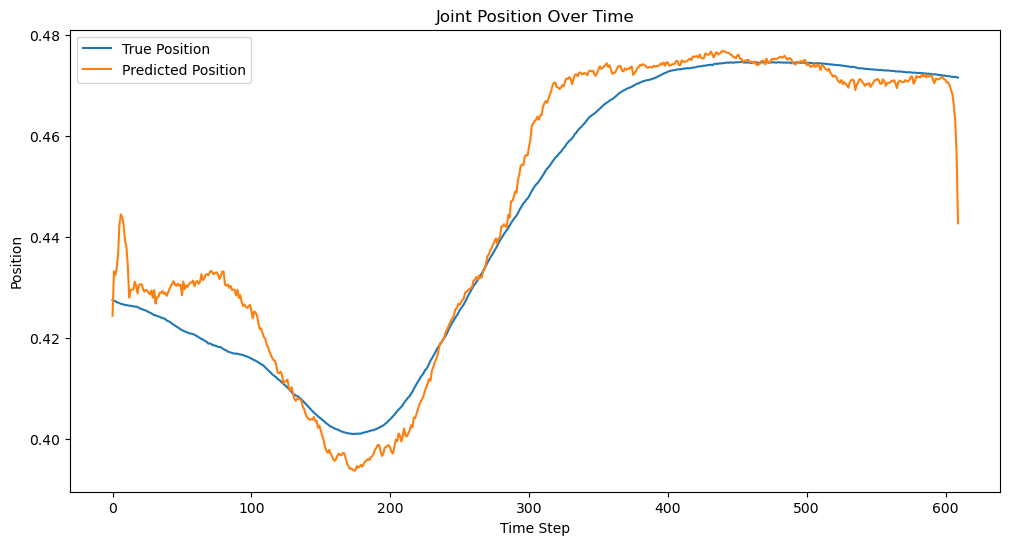

In [128]:
import matplotlib.pyplot as plt

# Select a sequence from the test set
X_sequence, Y_true_sequence, lengths = next(iter(test_loader))
sequence_idx = 1  # Local batch index, as we are selecting the first sequence in the batch
length = lengths_tensor[sequence_idx]  # Ensure the correct original length is used for this sequence

# Slice up to the true length of the sequence
X_sequence = X_sequence[sequence_idx:sequence_idx+1, :length].to(device)
Y_true_sequence = Y_true_sequence[sequence_idx:sequence_idx+1, :length].to(device)
lengths_sequence = lengths_tensor[sequence_idx:sequence_idx+1]

# Predict
model.eval()
with torch.no_grad():
    outputs, mask = model(X_sequence, lengths_sequence)  # Pass the correct sequence length for evaluation

# Denormalize the output and true values
def denormalize(data, mean, std):
    mean = mean.to(device).unsqueeze(0).unsqueeze(0)
    std = std.to(device).unsqueeze(0).unsqueeze(0)
    return data * std + mean

# Denormalize
Y_true_denorm = denormalize(Y_true_sequence, Y_mean, Y_std)
Y_pred_denorm = denormalize(outputs, Y_mean, Y_std)

# Convert to CPU and numpy arrays for plotting
Y_true_denorm = Y_true_denorm.squeeze(0).cpu().numpy()
Y_pred_denorm = Y_pred_denorm.squeeze(0).cpu().numpy()

# Plot true vs predicted positions for a specific joint and coordinate
joint_idx = 0  # First joint
coordinate_idx = 0  # X-coordinate

plt.figure(figsize=(12, 6))
plt.plot(
    Y_true_denorm[:length, joint_idx * 3 + coordinate_idx],  # Only plot non-padded values
    label='True Position',
)
plt.plot(
    Y_pred_denorm[:length, joint_idx * 3 + coordinate_idx],  # Only plot non-padded values
    label='Predicted Position',
)
plt.title('Joint Position Over Time')
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.legend()
plt.show()


In [129]:
lengths

tensor([992, 992, 992, 992, 992, 992, 992, 992, 992, 992, 992, 992, 992, 992,
        992, 992])

In [130]:
lengths_tensor[0]

tensor(474)

In [131]:
!jupyter nbconvert --to script Code/preprocessing/preprocess copy.ipynb

[NbConvertApp] WARNING | pattern 'copy.ipynb' matched no files
[NbConvertApp] Converting notebook Code/preprocessing/preprocess.ipynb to script
[NbConvertApp] Writing 17119 bytes to Code/preprocessing/preprocess.py
